In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

dataset_path = "/content/drive/My Drive/sem 7/cifar10"
os.makedirs(dataset_path, exist_ok=True)

print("Dataset akan disimpan di:", dataset_path)


Dataset akan disimpan di: /content/drive/My Drive/sem 7/cifar10


In [3]:
!pip install timm


In [4]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Transformasi dataset (resize 224)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.247, 0.243, 0.261))
])

# Download CIFAR-10 ke Google Drive
trainset = torchvision.datasets.CIFAR10(
    root=dataset_path, train=True, download=True, transform=transform_train
)

testset = torchvision.datasets.CIFAR10(
    root=dataset_path, train=False, download=True, transform=transform_test
)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

print("Trainloader dan Testloader siap!")


Trainloader dan Testloader siap!


In [5]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model DeiT-small & Swin-tiny
model_deit = timm.create_model('deit_small_patch16_224', pretrained=True, num_classes=10)
model_swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=10)

model_deit = model_deit.to(device)
model_swin = model_swin.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_deit = optim.AdamW(model_deit.parameters(), lr=1e-4, weight_decay=1e-4)
optimizer_swin = optim.AdamW(model_swin.parameters(), lr=1e-4, weight_decay=1e-4)

scheduler_deit = lr_scheduler.CosineAnnealingLR(optimizer_deit, T_max=10)
scheduler_swin = lr_scheduler.CosineAnnealingLR(optimizer_swin, T_max=10)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [6]:
def train_one_epoch(model, optimizer, loader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def validate(model, loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


In [7]:
num_epochs = 5  # gunakan 5 dulu agar cepat, nanti bisa ditambah

history = {
    'deit_train_loss': [], 'deit_train_acc': [],
    'deit_val_loss': [], 'deit_val_acc': [],
    'swin_train_loss': [], 'swin_train_acc': [],
    'swin_val_loss': [], 'swin_val_acc': []
}

for epoch in range(num_epochs):
    print(f"\n========== EPOCH {epoch+1}/{num_epochs} ==========\n")

    deit_train_loss, deit_train_acc = train_one_epoch(model_deit, optimizer_deit, trainloader)
    deit_val_loss, deit_val_acc = validate(model_deit, testloader)
    scheduler_deit.step()

    swin_train_loss, swin_train_acc = train_one_epoch(model_swin, optimizer_swin, trainloader)
    swin_val_loss, swin_val_acc = validate(model_swin, testloader)
    scheduler_swin.step()

    history['deit_train_loss'].append(deit_train_loss)
    history['deit_train_acc'].append(deit_train_acc)
    history['deit_val_loss'].append(deit_val_loss)
    history['deit_val_acc'].append(deit_val_acc)

    history['swin_train_loss'].append(swin_train_loss)
    history['swin_train_acc'].append(swin_train_acc)
    history['swin_val_loss'].append(swin_val_loss)
    history['swin_val_acc'].append(swin_val_acc)

    print(f"[DEIT] train_loss={deit_train_loss:.4f}, val_acc={deit_val_acc:.4f}")
    print(f"[SWIN] train_loss={swin_train_loss:.4f}, val_acc={swin_val_acc:.4f}")



========== EPOCH 1/5 ==========



100%|██████████| 157/157 [00:45<00:00,  3.48it/s]


[DEIT] train_loss=0.2013, val_acc=0.9550
[SWIN] train_loss=0.2354, val_acc=0.9626

========== EPOCH 2/5 ==========



100%|██████████| 157/157 [00:45<00:00,  3.47it/s]


[DEIT] train_loss=0.0751, val_acc=0.9646
[SWIN] train_loss=0.0958, val_acc=0.9560

========== EPOCH 3/5 ==========



100%|██████████| 157/157 [00:45<00:00,  3.48it/s]


[DEIT] train_loss=0.0464, val_acc=0.9644
[SWIN] train_loss=0.0628, val_acc=0.9607

========== EPOCH 4/5 ==========



100%|██████████| 157/157 [00:45<00:00,  3.46it/s]


[DEIT] train_loss=0.0298, val_acc=0.9698
[SWIN] train_loss=0.0457, val_acc=0.9643

========== EPOCH 5/5 ==========



100%|██████████| 157/157 [00:45<00:00,  3.45it/s]

[DEIT] train_loss=0.0172, val_acc=0.9699
[SWIN] train_loss=0.0274, val_acc=0.9653


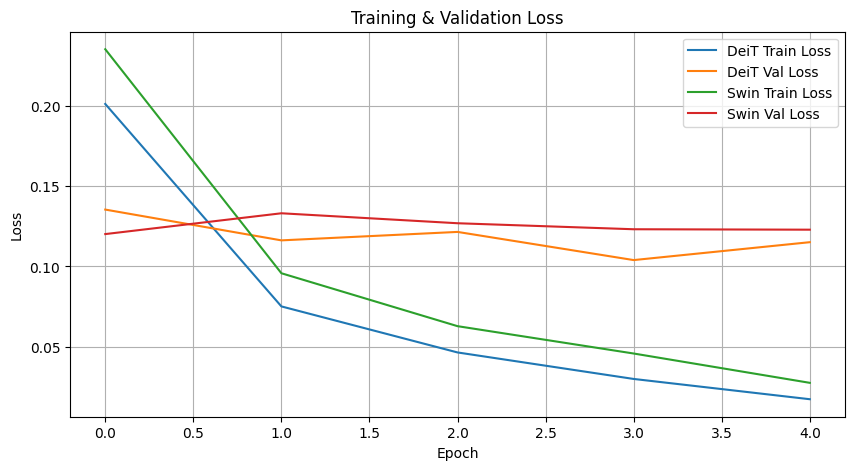

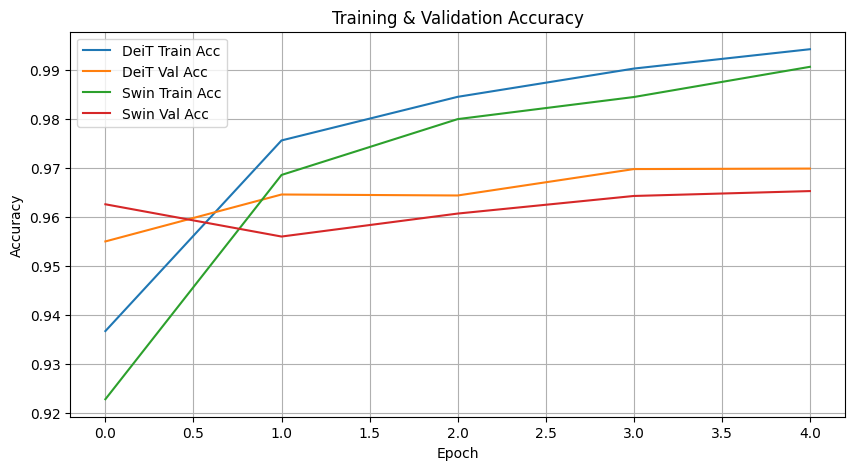

In [8]:
import matplotlib.pyplot as plt

# --- Grafik Loss ---
plt.figure(figsize=(10,5))
plt.plot(history['deit_train_loss'], label='DeiT Train Loss')
plt.plot(history['deit_val_loss'], label='DeiT Val Loss')
plt.plot(history['swin_train_loss'], label='Swin Train Loss')
plt.plot(history['swin_val_loss'], label='Swin Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- Grafik Accuracy ---
plt.figure(figsize=(10,5))
plt.plot(history['deit_train_acc'], label='DeiT Train Acc')
plt.plot(history['deit_val_acc'], label='DeiT Val Acc')
plt.plot(history['swin_train_acc'], label='Swin Train Acc')
plt.plot(history['swin_val_acc'], label='Swin Val Acc')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 800x800 with 0 Axes>

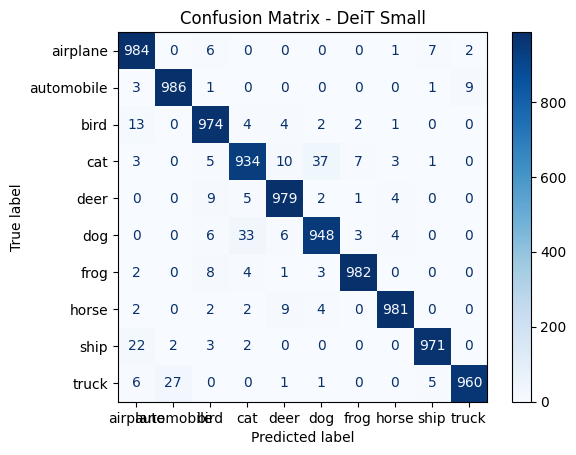

<Figure size 800x800 with 0 Axes>

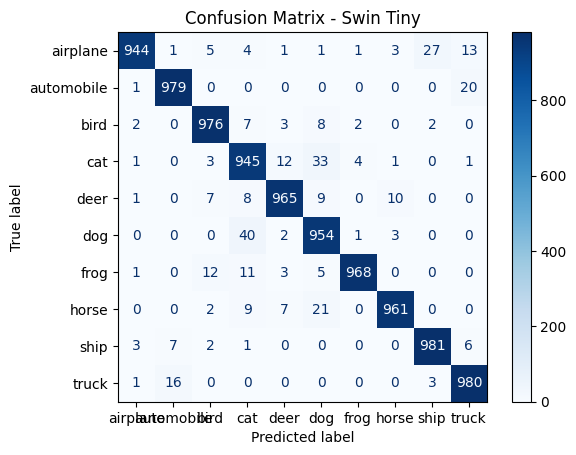

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_labels), np.array(all_preds)


# --- Confusion Matrix DeiT ---
labels_true, labels_pred = get_predictions(model_deit, testloader)
cm = confusion_matrix(labels_true, labels_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=trainset.classes)
plt.figure(figsize=(8,8))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - DeiT Small")
plt.show()

# --- Confusion Matrix Swin ---
labels_true, labels_pred = get_predictions(model_swin, testloader)
cm = confusion_matrix(labels_true, labels_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=trainset.classes)
plt.figure(figsize=(8,8))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Swin Tiny")
plt.show()


In [10]:
save_path = "/content/drive/My Drive/sem 7/saved_models"
os.makedirs(save_path, exist_ok=True)

# Simpan model DeiT
torch.save(model_deit.state_dict(), f"{save_path}/deit_small_cifar10.pth")
print("Model DeiT berhasil disimpan!")

# Simpan model Swin
torch.save(model_swin.state_dict(), f"{save_path}/swin_tiny_cifar10.pth")
print("Model Swin berhasil disimpan!")


Model DeiT berhasil disimpan!
Model Swin berhasil disimpan!
